In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam    
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy

C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 

In [6]:
def load_and_process_images(path_dir, class_labels, target_num_images):
    images = []
    labels = []
    min_images = 99999999
    class_images = {}
    
    for label, class_name in enumerate(class_labels):
        class_dir = os.path.join(path_dir, class_name)
        class_images[class_name] = []
        
        if not os.path.exists(class_dir):
            print(f"Directory '{class_name}' not found in '{path_dir}'. Skipping...")
            continue
        
        for jpg in os.listdir(class_dir):
            image_path = os.path.join(class_dir, jpg)
            image_high_resolution = cv2.imread(image_path)
            
            if image_high_resolution is None:
                print(f"Could not read image '{jpg}' in '{class_name}' directory. Skipping...")
                continue
            
            # print(f"Reading image '{jpg}' in '{class_name}' directory...")
            image_change_color = cv2.cvtColor(image_high_resolution, cv2.COLOR_BGR2RGB)
            image_low_resolution = cv2.resize(image_change_color, (256, 256))
            class_images[class_name].append(image_low_resolution)
            min_images = min(min_images, len(class_images[class_name]))
        print(f"Class '{class_name}' has {len(class_images[class_name])} images.")


    for class_name, images_list in class_images.items():
            images.extend(images_list)
            labels.extend([class_name] * len(images_list))
    
    return np.asarray(images), np.asarray(labels), min_images, class_images



dataset_directory = './Datasets/DataImages/'
class_labels = ['Catla', 'Cyprinus carpio', 'Grass Carp', 'Mori', 'Rohu', 'Silver']
target_num_images = 50

images, labels, min_images, class_images = load_and_process_images(dataset_directory, class_labels, target_num_images)

print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")


Class 'Catla' has 20 images.
Class 'Cyprinus carpio' has 50 images.
Class 'Grass Carp' has 11 images.
Class 'Mori' has 70 images.
Class 'Rohu' has 73 images.
Class 'Silver' has 47 images.
Number of images: 271
Number of labels: 271


In [7]:
def augment_data(images, labels, augment_function, num_augmented_images):
    augmented_images = []
    augmented_labels = []

    for i in range(len(images)):
        original_image = images[i]
        augmented_image = augment_function(original_image)
        augmented_images.append(augmented_image)
        augmented_labels.append(labels[i])

        if len(augmented_images) >= num_augmented_images:
            break

    return np.asarray(augmented_images), np.asarray(augmented_labels)

def horizontal_shift(image, shift_range=20):
    rows, cols, _ = image.shape
    random_shift = np.random.randint(-shift_range, shift_range + 1)
    matrix = np.float32([[1, 0, random_shift], [0, 1, 0]])
    shifted_image = cv2.warpAffine(image, matrix, (cols, rows))
    return shifted_image

def vertical_shift(image, shift_range=20):
    rows, cols, _ = image.shape
    random_shift = np.random.randint(-shift_range, shift_range + 1)
    matrix = np.float32([[1, 0, 0], [0, 1, random_shift]])
    shifted_image = cv2.warpAffine(image, matrix, (cols, rows))
    return shifted_image

def random_crop(image, crop_size=180):
    rows, cols, _ = image.shape
    top = np.random.randint(0, rows - crop_size)
    left = np.random.randint(0, cols - crop_size)
    cropped_image = image[top:top + crop_size, left:left + crop_size, :]
    return cv2.resize(cropped_image, (256, 256))

In [13]:
if len(images) == 0:
    print("No images found. Exiting...")
else:
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    X_train_augmented, y_train_augmented = augment_data(X_train, y_train, horizontal_shift, 50)
    X_train_augmented_v, y_train_augmented_v = augment_data(X_train, y_train, vertical_shift, 50)
    X_train_augmented_crop, y_train_augmented_crop = augment_data(X_train, y_train, random_crop, 50)

    # Concatenate the augmented data
    X_train = np.concatenate([X_train, X_train_augmented, X_train_augmented_v, X_train_augmented_crop])
    y_train = np.concatenate([y_train, y_train_augmented, y_train_augmented_v, y_train_augmented_crop])

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.fit_transform(y_test)

In [16]:
# print number of images in each class in y_train
unique, counts = np.unique(y_train, return_counts=True)
print("Number of images in each class in y_train:")
print(dict(zip(unique, counts)))

print(X_train.shape)


Number of images in each class in y_train:
{'Catla': 28, 'Cyprinus carpio': 58, 'Grass Carp': 21, 'Mori': 105, 'Rohu': 96, 'Silver': 58}
(366, 200, 200, 3)


In [17]:
for class_name, class_images in class_images.items():
    print(f"{class_name}: {len(class_images)}")

Catla: 20
Cyprinus carpio: 50
Grass Carp: 11
Mori: 70
Rohu: 73
Silver: 47


Epoch 1/20
12/12 [==============================] - 45s 3s/step - loss: 321.9182
Epoch 2/20
12/12 [==============================] - 41s 3s/step - loss: 321.6989
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 320.4864
Epoch 4/20
12/12 [==============================] - 36s 3s/step - loss: 322.7091
Epoch 5/20
12/12 [==============================] - 38s 3s/step - loss: 321.4968
Epoch 6/20
12/12 [==============================] - 36s 3s/step - loss: 320.6884
Epoch 7/20
12/12 [==============================] - 36s 3s/step - loss: 324.3257
Epoch 8/20
12/12 [==============================] - 37s 3s/step - loss: 321.6988
Epoch 9/20
12/12 [==============================] - 39s 3s/step - loss: 319.8802
Epoch 10/20
12/12 [==============================] - 39s 3s/step - loss: 321.6988
Epoch 11/20
12/12 [==============================] - 37s 3s/step - loss: 321.0926
Epoch 12/20
12/12 [==============================] - 39s 3s/step - loss: 321.4967
Epoch 13/20
12/12 [======

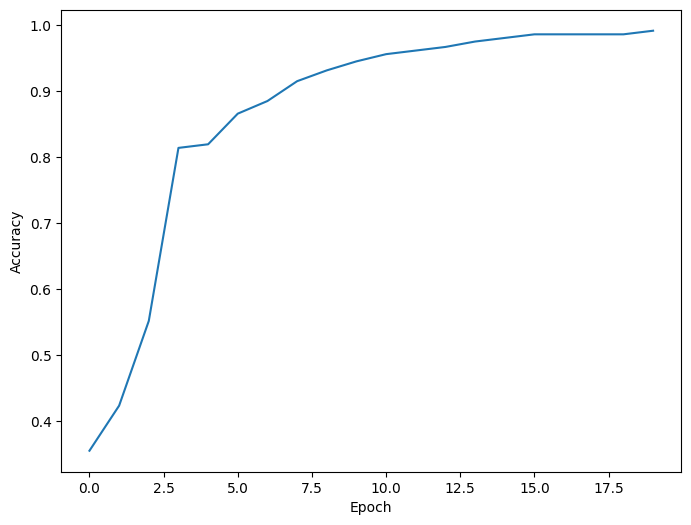

In [18]:
batch_size = 32

class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0, name="contrastive_loss"):
        super(ContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def call(self, y_true, y_pred):
        y_pred = tf.math.l2_normalize(y_pred, axis=1)
        
        y_true = tf.cast(y_true, tf.float32)
    
        similarity_matrix = tf.matmul(y_pred, y_pred, transpose_a=False, transpose_b=True)
        
        similarity_matrix /= self.temperature
                
        contrastive_loss = -tf.reduce_mean(
            tf.reduce_sum(y_true * tf.math.log_softmax(similarity_matrix, axis=1), axis=1)
        )
        
        return contrastive_loss
    

# Define SimCLR model
def create_simclr_model(input_shape, num_classes):
    base_encoder = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
    base_encoder.trainable = False
    
    inputs = layers.Input(shape=input_shape, name='input_image')
    
    x = base_encoder(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    model = models.Model(inputs=inputs, outputs=x, name='simclr_model')
    return model

input_shape = (256, 256, 3)
num_classes = len(class_labels)
simclr_model = create_simclr_model(input_shape, num_classes)

contrastive_loss = ContrastiveLoss()

simclr_model.compile(optimizer=Adam(), loss=contrastive_loss)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X_train)).batch(batch_size)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train_encoded).shuffle(len(y_train_encoded)).batch(batch_size)
train_dataset = tf.data.Dataset.zip((train_dataset, train_labels_dataset))

epochs = 20 
simclr_model.fit(train_dataset, epochs=epochs)

classification_model = models.Sequential([
    simclr_model,
    layers.Dense(num_classes, activation='softmax')
])

classification_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train_encoded).batch(batch_size)
train_dataset = tf.data.Dataset.zip((train_dataset, train_labels_dataset))

# Train the classification model
history = classification_model.fit(train_dataset, epochs=epochs)

# Evaluate the model
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test_encoded).batch(batch_size)
test_dataset = tf.data.Dataset.zip((test_dataset, test_labels_dataset))


plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [21]:
accuracy = classification_model.evaluate(test_dataset)[1]
print(f"Accuracy on the test set: {accuracy}")

2/2 [==============================] - 5s 2s/step - loss: 0.6904 - accuracy: 0.9091
Accuracy on the test set: 0.9090909361839294


In [22]:
from sklearn.metrics import classification_report

predictions = classification_model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

class_names = class_labels  # Assuming class_labels is a list of strings

# Convert class_names to a dictionary for easy lookup
class_dict = {class_name: i for i, class_name in enumerate(class_names)}

# Convert string labels in y_test to integers
y_test_int = np.array([class_dict[label] for label in y_test])

for i in range(len(y_test_int)):
    true_class = class_names[y_test_int[i]]
    predicted_class = class_names[predicted_classes[i]]
    print(f"{true_class}, {predicted_class}")

print(classification_report(y_test_int, predicted_classes, target_names=class_names))


2/2 [==============================] - 5s 2s/step
Cyprinus carpio, Cyprinus carpio
Mori, Mori
Grass Carp, Mori
Mori, Mori
Rohu, Mori
Mori, Mori
Rohu, Rohu
Cyprinus carpio, Cyprinus carpio
Rohu, Rohu
Silver, Silver
Rohu, Rohu
Silver, Silver
Silver, Silver
Mori, Mori
Rohu, Rohu
Rohu, Rohu
Silver, Silver
Mori, Mori
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Rohu, Rohu
Silver, Silver
Cyprinus carpio, Cyprinus carpio
Cyprinus carpio, Cyprinus carpio
Rohu, Rohu
Catla, Catla
Cyprinus carpio, Cyprinus carpio
Rohu, Rohu
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Mori, Mori
Silver, Silver
Silver, Silver
Catla, Catla
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Mori, Rohu
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Mori, Mori
Silver, Silver
Catla, Catla
Grass Carp, Mori
Rohu, Rohu
Mori, Mori
Rohu, Rohu
Mori, Mori
Rohu, Mori
Catla, Catla
Rohu, Rohu
Silver, Silver
Silver, Silver
Mori, Mori
                 precision    recall  f1-score   support

       

C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\m